# Normalizing Flows Overview

Normalizing Flows is a rich family of distributions. They were described by [Rezende and Mohamed](https://arxiv.org/abs/1505.05770), and their experiments proved the importance of studying them further. Some extensions like that of [Tomczak and Welling](https://arxiv.org/abs/1611.09630) made partially/full rank Gaussian approximations for high dimensional spaces computationally tractable. 

This notebook reveals some tips and tricks for using normalizing flows effectively in PyMC3.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
from theano import theano, tensor as tt
from collections import Counter

pm.set_tt_rng(42)
np.random.seed(42)

## Theory

Normalizing flows is a series of invertible transformations on an initial distribution. 

$$z_K = f_K \circ \dots \circ f_2 \circ f_1(z_0) $$

In this case, we can compute a tractable density for the flow.

$$\ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^{K}\ln \left|\frac{\partial f_k}{\partial z_{k-1}}\right|$$

Here, every $f_k$ is a parametric function with a well-defined determinant. The transformation used is up to the user; for example, the simplest flow is an affine transform:

$$z = loc(scale(z_0)) = \mu + \sigma * z_0 $$

In this case, we get a mean field approximation if $z_0 \sim \mathcal{N}(0, 1)$

## Flow Formulas

In PyMC3 there are flexible ways to define flows with formulas. There are currently 5 types defined:

* Loc (`loc`): $z' = z + \mu$
* Scale (`scale`): $z' = \sigma * z$
* Planar (`planar`): $z' = z + u * \tanh(w^T z + b)$
* Radial (`radial`): $z' = z + \beta (\alpha + ||z-z_r||)^{-1}(z-z_r)$
* Householder (`hh`): $z' = H z$

Formulae can be composed as a string, e.g. `'scale-loc'`, `'scale-hh*4-loc'`, `'panar*10'`. Each step is separated with `'-'`, and repeated flows are defined with `'*'` in the form of `'<flow>*<#repeats>'`.

Flow-based approximations in PyMC3 are based on the `NormalizingFlow` class, with corresponding inference classes named using the `NF` abbreviation (analogous to how `ADVI` and `SVGD` are treated in PyMC3).

Concretely, an approximation is represented by:

In [2]:
pm.NormalizingFlow

pymc3.variational.approximations.NormalizingFlow

While an inference class is:

In [3]:
pm.NFVI

pymc3.variational.inference.NFVI

## Flow patterns

Composing flows requires some understanding of the target output. Flows that are too complex might not converge, whereas if they are too simple, they may not accurately estimate the posterior. 

Let's start simply:

In [4]:
with pm.Model() as dummy:
    
    N = pm.Normal('N', shape=(100,))

### Mean Field connectivity

Let's apply the transformation corresponding to the mean-field family to begin with:

In [5]:
pm.NormalizingFlow('scale-loc', model=dummy)

### Full Rank Normal connectivity

We can get a full rank model with dense covariance matrix using **householder flows** (hh). One `hh` flow adds exactly one rank to the covariance matrix, so for a full rank matrix we need `K=ndim` householder flows. hh flows are volume-preserving, so we need to change the scaling if we want our posterior to have unit variance for the latent variables. 

After we specify the covariance with a combination of `'scale-hh*K'`, we then add location shift with the `loc` flow. We now have a full-rank analog:

In [6]:
pm.NormalizingFlow('scale-hh*100-loc', model=dummy)

A more interesting case is when we do not expect a lot of interactions within the posterior. In this case, where our covariance is expected to be sparse, we can constrain it by defining a *low rank* approximation family. 

This has the additional benefit of reducing the computational cost of approximating the model.

In [7]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy) 

Parameters can be initialized randomly, using the `jitter` argument to specify the scale of the randomness.

In [8]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy, jitter=.001) # LowRank

### Planar and Radial Flows

* Planar (`planar`): $z' = z + u * \tanh(w^T z + b)$
* Radial (`radial`): $z' = z + \beta (\alpha + ||z-z_r||)^{-1}(z-z_r)$

Planar flows are useful for splitting the incoming distribution into two parts, which allows multimodal distributions to be modeled. 

Similarly, a radial flow changes density around a specific reference point.

## Simulated data example

There were 4 potential functions illustrated in the [original paper](https://arxiv.org/abs/1505.05770), which we can replicate here. Inference can be unstable in multimodal cases, but there are strategies for dealing with them.

First, let's specify the potential functions:

In [9]:
def w1(z):
    return tt.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tt.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tt.exp(-(z[0]-1.)/.3))**-1

def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) + 
                                                      tt.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = z.T
    return .5*((z[1]-w1(z))/.4)**2 + 0.1*tt.abs_(z[0])

def pot3(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.35)**2) + 
                   tt.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2)) + 0.1*tt.abs_(z[0])

def pot4(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.4)**2) + 
                   tt.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2)) + 0.1*tt.abs_(z[0])

z = tt.matrix('z')
z.tag.test_value = pm.floatX([[0., 0.]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))

In [10]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax

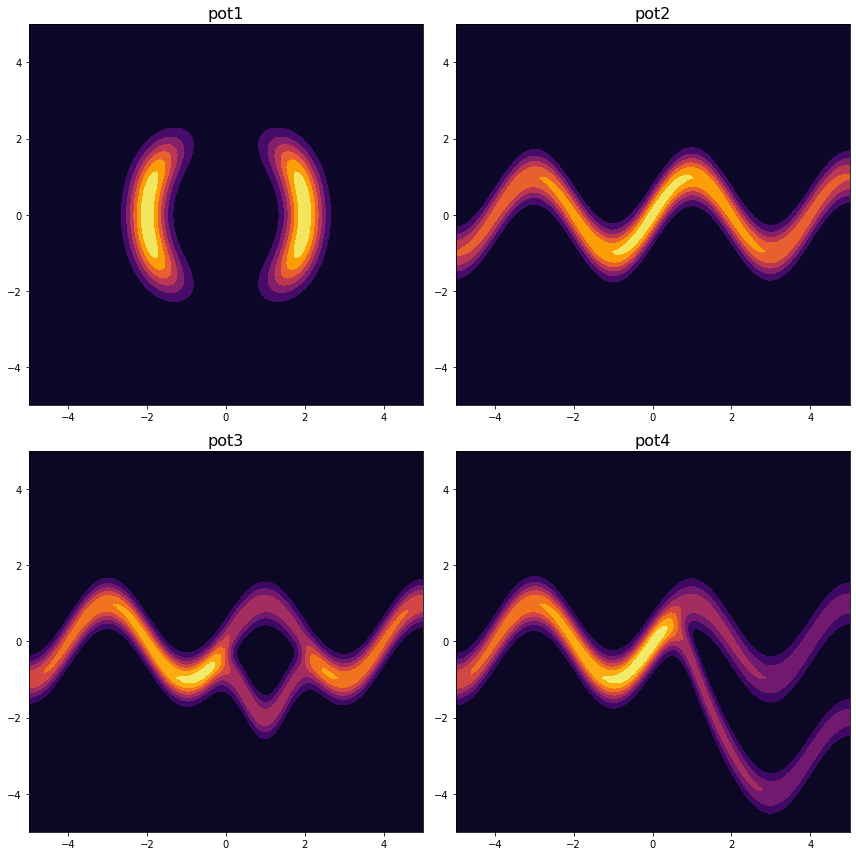

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
contour_pot(pot1f, ax[0], 'pot1', );
contour_pot(pot2f, ax[1], 'pot2');
contour_pot(pot3f, ax[2], 'pot3');
contour_pot(pot4f, ax[3], 'pot4');
fig.tight_layout()

## Reproducing first potential function

In [12]:
from pymc3.distributions.dist_math import bound
def cust_logp(z):
    #return bound(-pot1(z), z>-5, z<5)
    return -pot1(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))

### NUTS
Let's use NUTS first. Just to have a look how good is it's approximation.

> Note you may need to rerun the model a couple of times, as the sampler/estimator might not fully explore function due to multimodality.

In [13]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(1000, init='auto', cores=2, start=[dict(pot1=np.array([-2, 0])),
                                                         dict(pot1=np.array([2, 0]))])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30246096720680476, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


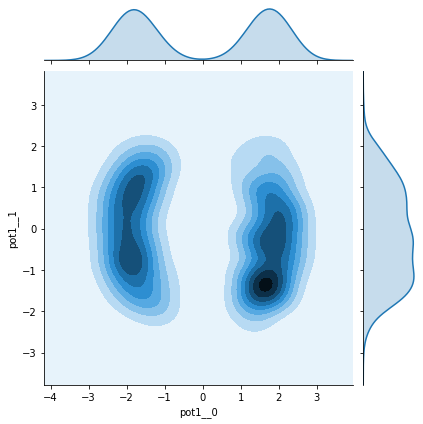

In [14]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

### Normalizing flows

As a first (naive) try with flows, we will keep things simple: Let's use just 2 planar flows and see what we get:

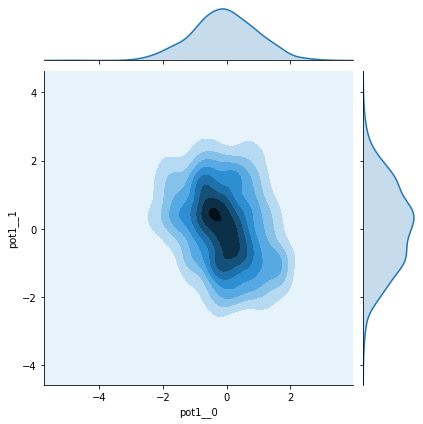

In [15]:
with pot1m:
    inference = pm.NFVI('planar*2', jitter=1)
    
## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');

#### Tracking gradients

It is illustrative to track gradients as well as parameters. In this setup, different sampling points can give different gradients because a single sampled point tends to collapse to a mode.

Here are the parameters of the model:

In [16]:
inference.approx.params

[b, u, w, b, u, w]

We also require an objective:

In [17]:
inference.objective(nmc=None)

Elemwise{mul,no_inplace}.0

Theano can be used to calcuate the gradient of the objective with respect to the parameters:

In [18]:
with theano.configparser.change_flags(compute_test_value='off'):
    grads = tt.grad(inference.objective(None), inference.approx.params)
grads

[Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0]

If we want to keep track of the gradient changes during the inference, we warp them in a pymc3 callback:

In [19]:
from collections import defaultdict, OrderedDict
from itertools import count

@theano.configparser.change_flags(compute_test_value='off')
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ['%s_%d' % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(**OrderedDict(
      [(name, v.eval) for name, v in zip(names, params)] + [('grad_' + name, v.eval) for name, v in zip(names, grads)]
    ))

tracker = get_tracker(inference)

In [20]:
tracker.whatchdict

{'b_0': <bound method Variable.eval of b>,
 'u_0': <bound method Variable.eval of u>,
 'w_0': <bound method Variable.eval of w>,
 'b_1': <bound method Variable.eval of b>,
 'u_1': <bound method Variable.eval of u>,
 'w_1': <bound method Variable.eval of w>,
 'grad_b_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_b_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>}

In [21]:
inference.fit(30000, obj_optimizer=pm.adagrad_window(learning_rate=.01), callbacks=[tracker])

Finished [100%]: Average Loss = -0.89074


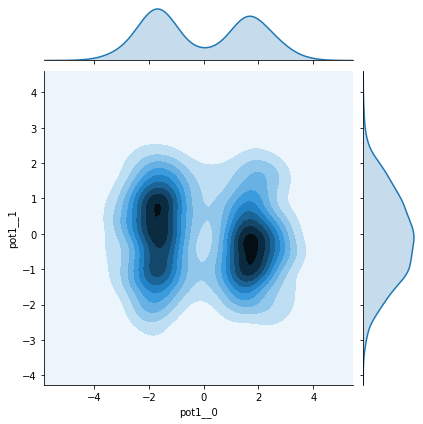

In [22]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

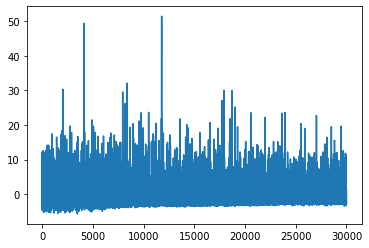

In [23]:
plt.plot(inference.hist);

As you can see, the objective history is not very informative here. This is where the gradient tracker can be more informative.

In [24]:
trackername = ['u_0', 'w_0', 'b_0', 'u_1', 'w_1', 'b_1', 
               'grad_u_0', 'grad_w_0', 'grad_b_0', 'grad_u_1', 'grad_w_1', 'grad_b_1']

def plot_tracker_results(tracker):
    fig, ax = plt.subplots(len(tracker.hist)//2, 2, figsize=(16, len(tracker.hist)//2*2.3))
    ax = ax.flatten()
    #names = list(tracker.hist.keys())
    names = trackername
    gnames = names[len(names)//2:]
    names = names[:len(names)//2]
    pairnames = zip(names, gnames)
    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i*2]
        right = ax[i*2+1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title('Gradient of %s' % name)
        left.set_title('Param trace of %s' % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, '-')
            right.plot(g, 'o', alpha=1/s/10)
        left.legend([name + '_%d' % j for j in range(len(names))])
        right.legend([gname + '_%d' % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()

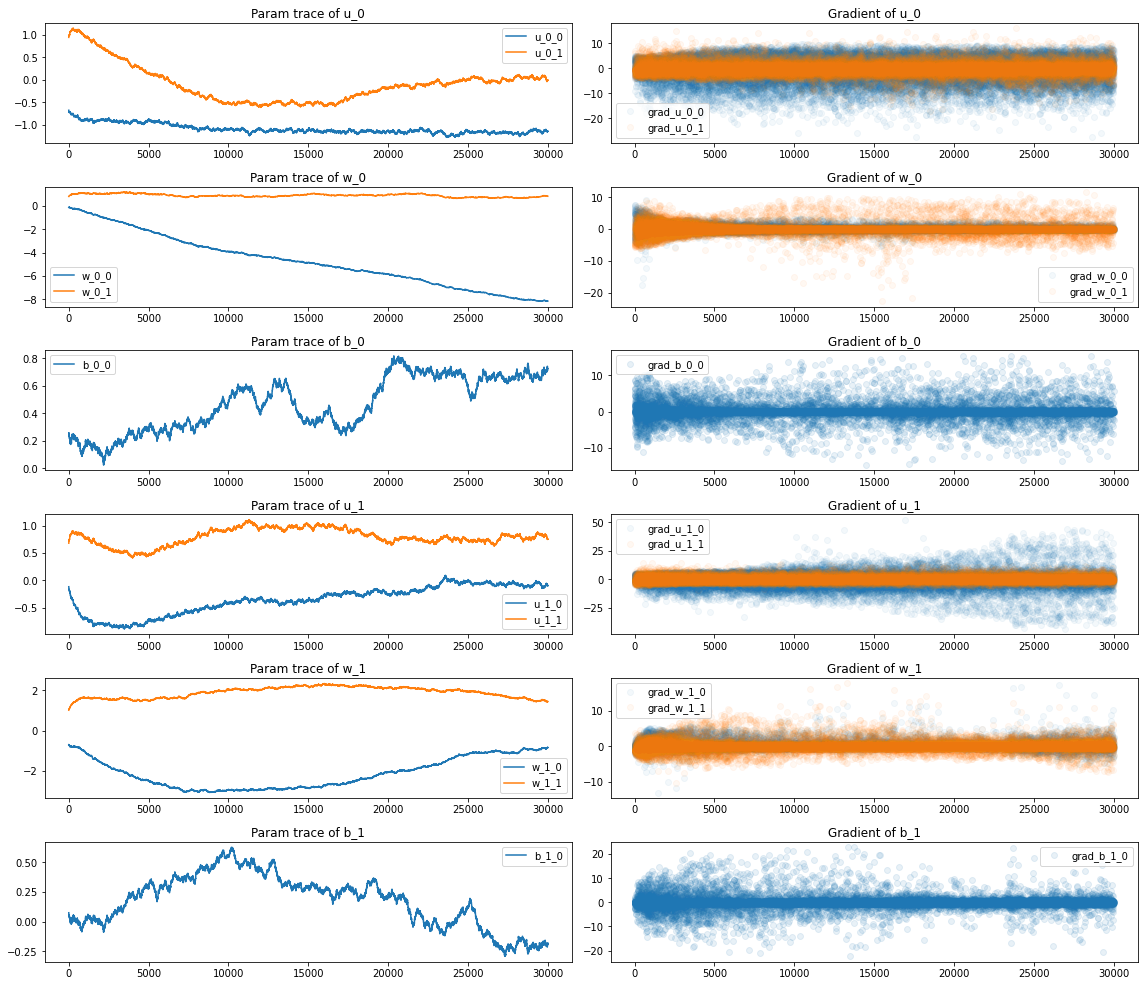

In [25]:
plot_tracker_results(tracker);

Inference **is often unstable**, some parameters are not well fitted as they poorly influence the resulting posterior. 

In a multimodal setting, the dominant mode might well change from run to run.

### Going deeper

We can try to improve our approximation by adding flows; in the original paper they used both 8 and 32. Let's try using 8 here.

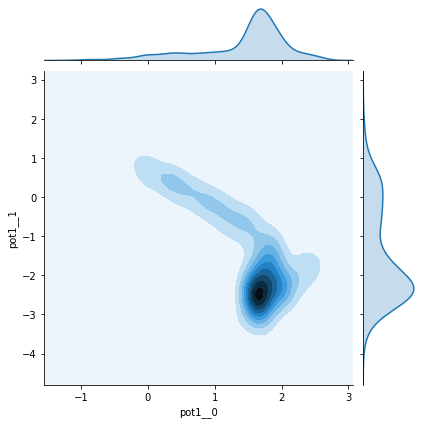

In [26]:
with pot1m:
    inference = pm.NFVI('planar*8', jitter=1.)
    
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');

We can try for a more robust fit by allocating more samples to `obj_n_mc` in `fit`, which controls the number of Monte Carlo samples used to approximate the gradient. 

In [27]:
inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=100, 
              callbacks=[pm.callbacks.CheckParametersConvergence()])

Finished [100%]: Average Loss = -1.7772


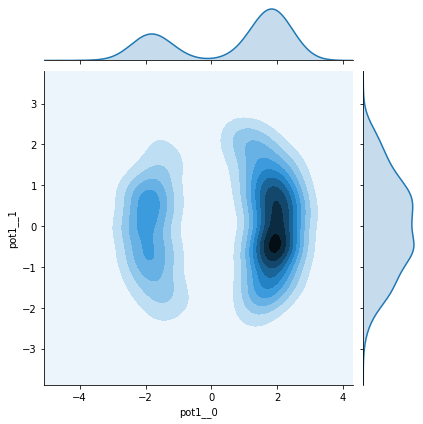

In [28]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

This is a noticeable improvement. Here, we see that flows are able to characterize the multimodality of a given posterior, but as we have seen, they are hard to fit. The initial point of the optimization matters in general for the multimodal case.

### MCMC vs NFVI

Let's use another potential function, and compare the sampling using NUTS to what we get with NF:

In [29]:
def cust_logp(z):
    return -pot4(z)

with pm.Model() as pot_m:
    pm.DensityDist('pot_func', logp=cust_logp, shape=(2,))

In [30]:
with pot_m:
    traceNUTS = pm.sample(3000, tune=1000, target_accept=0.9, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot_func]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 16 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5722625904068807, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8154901665548793, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [31]:
formula = 'planar*10'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)

Finished [100%]: Average Loss = -2.5043


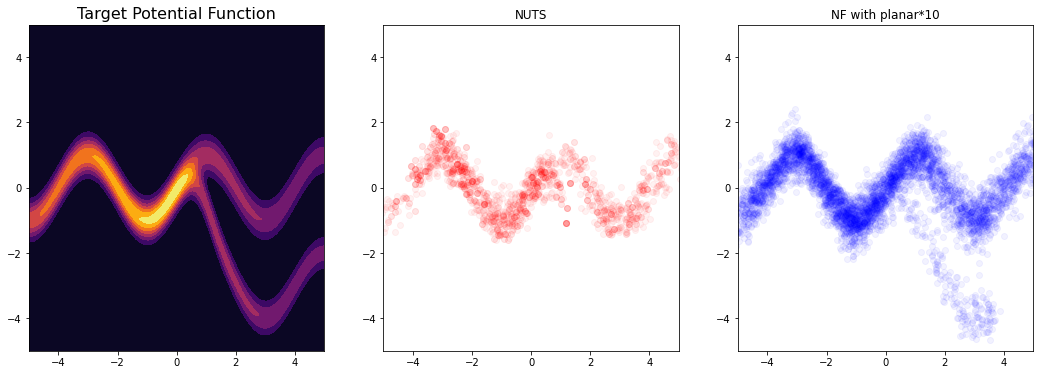

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
contour_pot(pot4f, ax[0], 'Target Potential Function');

ax[1].scatter(traceNUTS['pot_func'][:,0], traceNUTS['pot_func'][:,1],c='r',alpha=.05)
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)
ax[1].set_title('NUTS')

ax[2].scatter(traceNF['pot_func'][:,0], traceNF['pot_func'][:,1],c='b',alpha=.05)
ax[2].set_xlim(-5,5)
ax[2].set_ylim(-5,5)
ax[2].set_title('NF with ' + formula);

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3   3.9.0
theano  1.0.4
numpy   1.18.5
seaborn 0.10.1
last updated: Mon Jun 15 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
